# Forecasting Gas Prices in Canada with SARIMA

This document details the process of modeling and forecasting gas prices across major cities in Canada using the Seasonal Autoregressive Integrated Moving Average (SARIMA) model. The goal is to predict future gas prices based on historical data.

## Data Loading

First, we load the dataset containing historical gas prices for various major cities in Canada, including a country-wide average. The data spans from November 1992 to January 2024.

In [40]:
import pandas as pd

# Load the dataset
data = pd.read_csv('data/gas_data_clean.csv')

# Display the first few rows of the dataset to understand its structure
data.head()

,Geography,Nov-92,Dec-92,Jan-93,Feb-93,Mar-93,Apr-93,May-93,Jun-93,Jul-93,...,Apr-23,May-23,Jun-23,Jul-23,Aug-23,Sep-23,Oct-23,Nov-23,Dec-23,Jan-24
0,Canada,56.1,56.1,55.9,54.9,54.0,54.1,54.5,55.5,55.2,...,160.1,158.8,161.6,163.1,170.6,168.3,157.4,152.2,145.4,144.1
1,"St. John's, Newfoundland and Labrador",59.4,59.2,57.1,57.1,56.4,56.4,57.4,58.4,59.5,...,174.3,165.5,168.4,174.8,188.0,190.0,173.9,168.3,163.0,161.2
2,"Charlottetown and Summerside, Prince Edward Is...",60.9,60.9,58.9,58.9,58.9,56.4,55.9,55.6,56.2,...,168.4,161.2,163.4,173.7,185.3,184.8,165.7,161.3,158.0,156.6
3,"Halifax, Nova Scotia",57.3,56.0,52.2,50.9,49.2,49.6,51.3,51.8,53.6,...,163.2,151.4,153.1,174.7,185.0,182.2,166.3,161.6,154.3,154.5
4,"Saint John, New Brunswick",56.1,55.3,54.6,54.5,54.5,54.4,54.7,54.8,55.7,...,169.3,159.1,161.4,170.6,182.7,184.5,167.3,160.3,154.8,152.7



## Initial Data Exploration and SARIMA Model Setup

The dataset contains time series data of gas prices. Our initial focus will be on the country-wide average to develop a forecasting model. The SARIMA model requires determining the order of differencing (d), the autoregressive (AR) terms (p), and the moving average (MA) terms (q), along with their seasonal counterparts (P, D, Q, S).

### Plotting the Time Series

We start by visualizing the country-wide average gas prices to identify trends and seasonality.


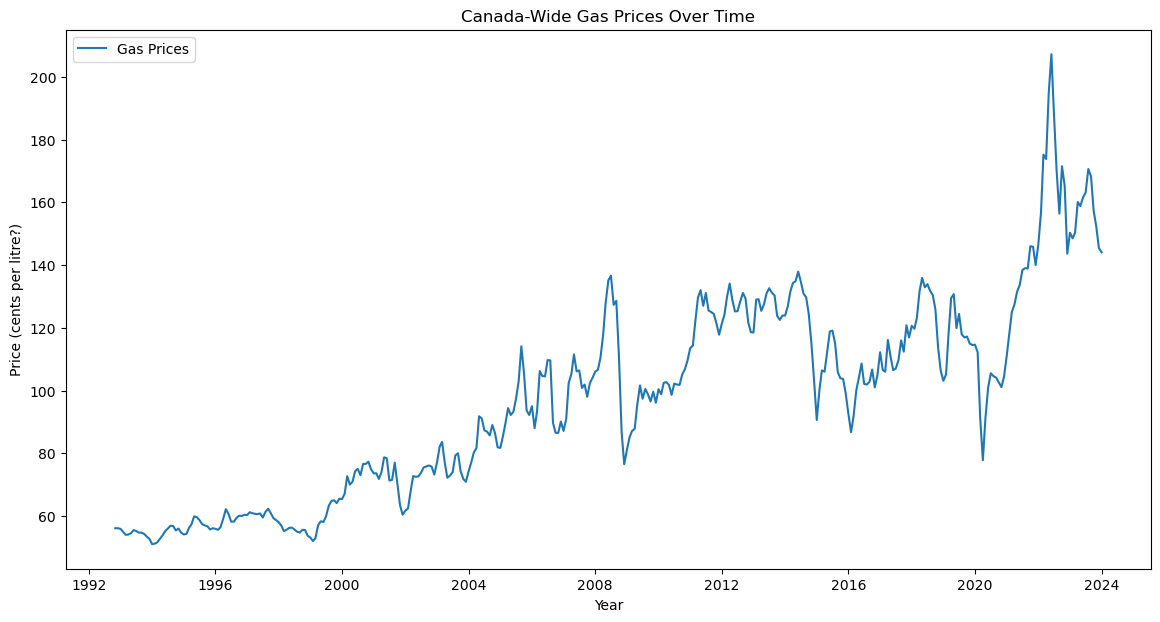

In [41]:
import matplotlib.pyplot as plt

# Extract Canada-wide data
canada_gas_prices = data[data['Geography'] == 'Canada'].drop('Geography', axis=1).T
canada_gas_prices.columns = ['Price']
canada_gas_prices.index = pd.to_datetime(canada_gas_prices.index, format='%b-%y')

# Plotting the time series
plt.figure(figsize=(14, 7))
plt.plot(canada_gas_prices.index, canada_gas_prices['Price'], label='Gas Prices')
plt.title('Canada-Wide Gas Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Price (cents per litre?)')
plt.legend()
plt.show()

### Stationarity Test and Differencing

To fit a SARIMA model, the time series must be stationary. We use the Augmented Dickey-Fuller (ADF) test to check for stationarity and apply differencing if necessary.


In [42]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(canada_gas_prices['Price'])

# Display the ADF test result
adf_result

(-0.9987554322253941,
 0.753717957984426,
 10,
 364,
 {'1%': -3.4484434475193777,
  '5%': -2.869513170510808,
  '10%': -2.571017574266393},
 2199.3135203403335)

### ACF and PACF Analysis

After differencing the data to achieve stationarity, we analyze the AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF) to guide the selection of SARIMA parameters.


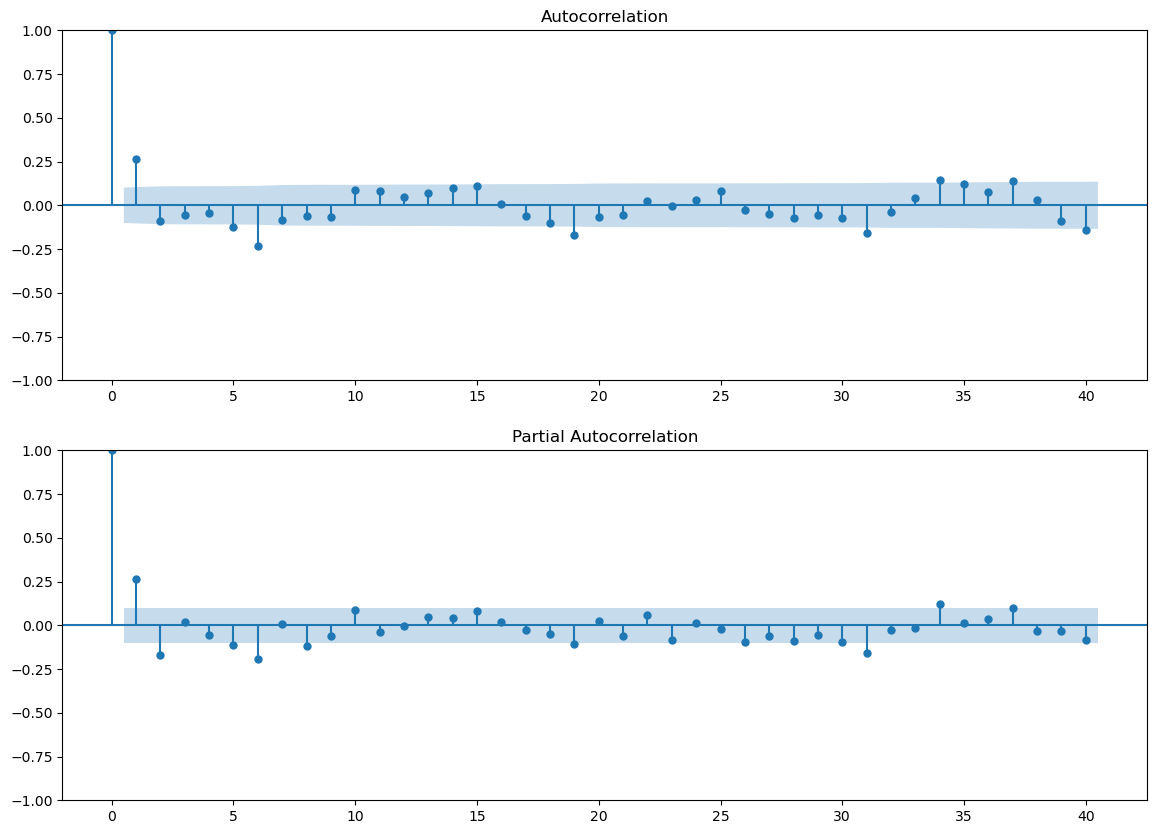

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Differencing the series to achieve stationarity
canada_gas_prices_diff = canada_gas_prices['Price'].diff().dropna()

# Plotting ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(canada_gas_prices_diff, lags=40, ax=ax1)
plot_pacf(canada_gas_prices_diff, lags=40, ax=ax2)
plt.show()

## SARIMA Model Fitting

Based on the ACF and PACF analysis, we initially fit a SARIMA model and then adjust its parameters to improve performance. The final model is used to forecast future gas prices.

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initial SARIMA model fitting
model = SARIMAX(canada_gas_prices['Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Displaying the model summary
model_fit.summary()

c:\Users\matta\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matta\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  375
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1116.102
Date:                            Tue, 12 Mar 2024   AIC                           2242.203
Time:                                    17:08:41   BIC                           2261.661
Sample:                                11-01-1992   HQIC                          2249.939
                                     - 01-01-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4015      0.096     -4.204      0.000      -0.589      -0.214
ma.L1          0.6556      0.082      8.042      0.000       0.496       0.815
ar.S.L12      -0.0622      0.063     -0.982      0.326      -0.186       0.062
ma.S.L12      -0.9560      0.056    -17.061      0.000      -1.066      -0.846
sigma2        25.6571      1.330     19.286      0.000      23.050      28.265
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               218.64
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):              11.16   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


### Model Adjustments

Based on the initial model's performance, we adjust parameters to improve the fit. This involves iterating over different model specifications.


In [45]:
# Adjusted SARIMA model without the seasonal AR component
model_adjusted = SARIMAX(canada_gas_prices['Price'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
model_adjusted_fit = model_adjusted.fit(disp=False)

# Displaying the adjusted model summary
model_adjusted_fit.summary()

c:\Users\matta\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matta\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  375
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1116.674
Date:                            Tue, 12 Mar 2024   AIC                           2241.347
Time:                                    17:08:42   BIC                           2256.914
Sample:                                11-01-1992   HQIC                          2247.536
                                     - 01-01-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4003      0.093     -4.292      0.000      -0.583      -0.217
ma.L1          0.6582      0.080      8.198      0.000       0.501       0.816
ma.S.L12      -0.9883      0.140     -7.079      0.000      -1.262      -0.715
sigma2        25.2342      3.266      7.727      0.000      18.833      31.635
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               225.43
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):              11.09   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


### Forecasting and Plotting

Finally, we use the adjusted model to forecast gas prices over the next 5 years and plot the results.


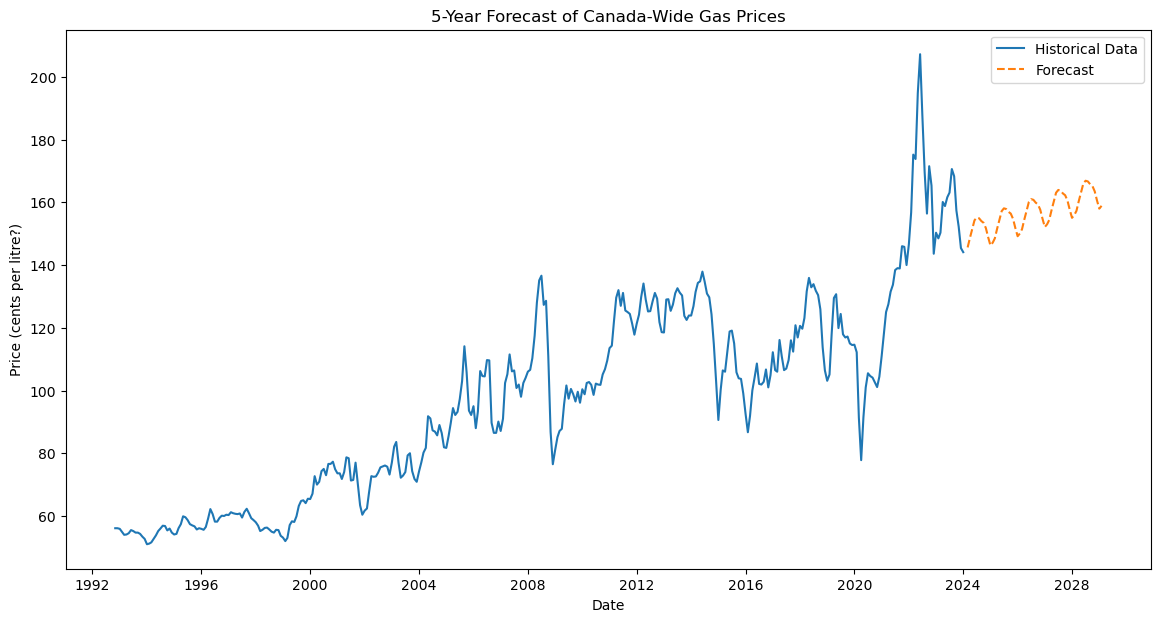

In [46]:
# Forecasting the next 5 years and plotting
forecast_5y = model_adjusted_fit.get_forecast(steps=60)
forecast_5y_index = pd.date_range(canada_gas_prices.index[-1] + pd.offsets.MonthBegin(1), periods=60, freq='M')
forecast_5y_mean = forecast_5y.predicted_mean

# Plotting the forecast
plt.figure(figsize=(14, 7))
plt.plot(canada_gas_prices.index, canada_gas_prices['Price'], label='Historical Data')
plt.plot(forecast_5y_index, forecast_5y_mean, label='Forecast', linestyle='--')
plt.title('5-Year Forecast of Canada-Wide Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price (cents per litre?)')
plt.legend()
plt.show()

This concludes our analysis and forecasting of gas prices in Canada using the SARIMA model. By iteratively refining the model parameters and employing statistical tests for stationarity, we've developed a forecasting model that provides insights into future gas price trends, aiding in planning and decision-making processes.

### Confidence Intervals?

What about trying to add some confidence intervals.

c:\Users\matta\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matta\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


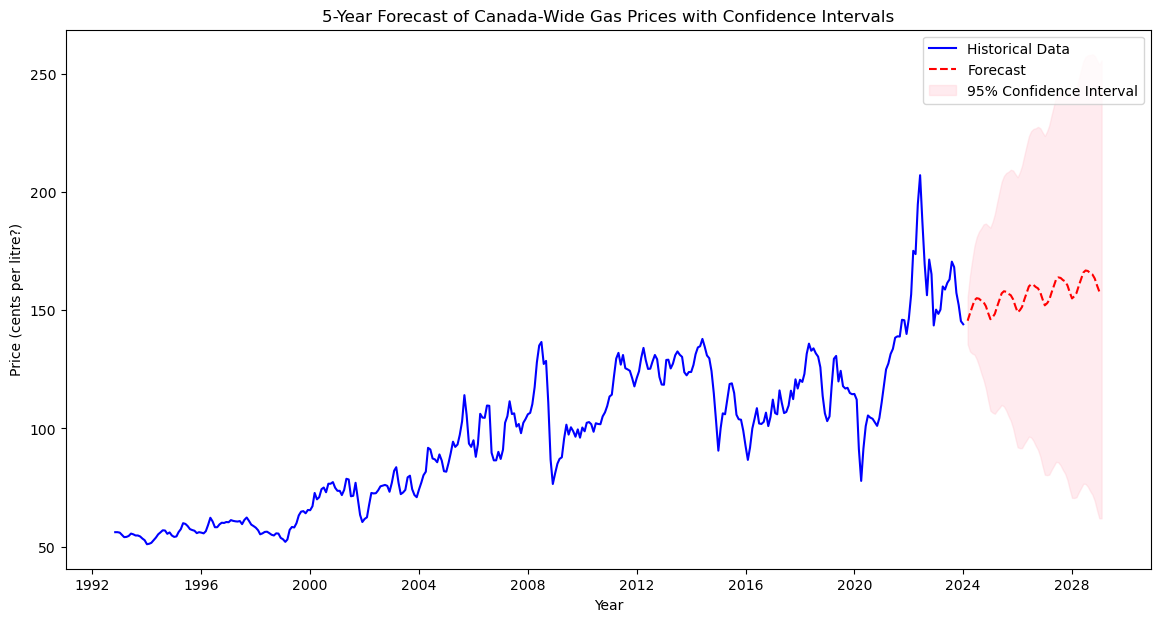

In [47]:
# Re-attempting the entire forecasting process including plotting with confidence intervals from the top
# This includes fitting the model, forecasting, and plotting with the correction for any previous issues.

# Re-fitting the adjusted SARIMA model with the previously determined optimal parameters
model_readjusted = SARIMAX(canada_gas_prices['Price'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
model_readjusted_fit = model_readjusted.fit(disp=False)

# Forecasting the next 5 years (60 months) again to ensure coherence
forecast_5y_readjusted = model_readjusted_fit.get_forecast(steps=60)
forecast_5y_readjusted_index = pd.date_range(canada_gas_prices.index[-1] + pd.offsets.MonthBegin(1), periods=60, freq='M')
forecast_5y_readjusted_mean = forecast_5y_readjusted.predicted_mean
confidence_intervals_readjusted = forecast_5y_readjusted.conf_int()

# Attempting the plot again with corrections
plt.figure(figsize=(14, 7))
plt.plot(canada_gas_prices.index, canada_gas_prices['Price'], label='Historical Data', color='blue')
plt.plot(forecast_5y_readjusted_index, forecast_5y_readjusted_mean, label='Forecast', color='red', linestyle='--')

# Confidence intervals for the adjusted forecast
plt.fill_between(forecast_5y_readjusted_index, 
                 confidence_intervals_readjusted.iloc[:, 0], 
                 confidence_intervals_readjusted.iloc[:, 1], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('5-Year Forecast of Canada-Wide Gas Prices with Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('Price (cents per litre?)')
plt.legend()
plt.show()


# Forecasting Gas Prices in Canada for the Next 12 Months with SARIMA

This document outlines the steps to forecast gas prices in Canada for the next 12 months using the SARIMA model. We include confidence intervals to represent the prediction uncertainty and display the forecasted values in a table for clarity.

## SARIMA Model Recap

We use a SARIMA model with parameters `(1, 1, 1)x(0, 1, 1, 12)` based on previous analyses for its ability to model time series data with seasonal patterns.

## Forecasting and Visualization

We forecast gas prices for the next 12 months and calculate the 95% confidence intervals to quantify prediction uncertainty. The forecast is visualized using matplotlib, showing both the predicted values and their confidence intervals.


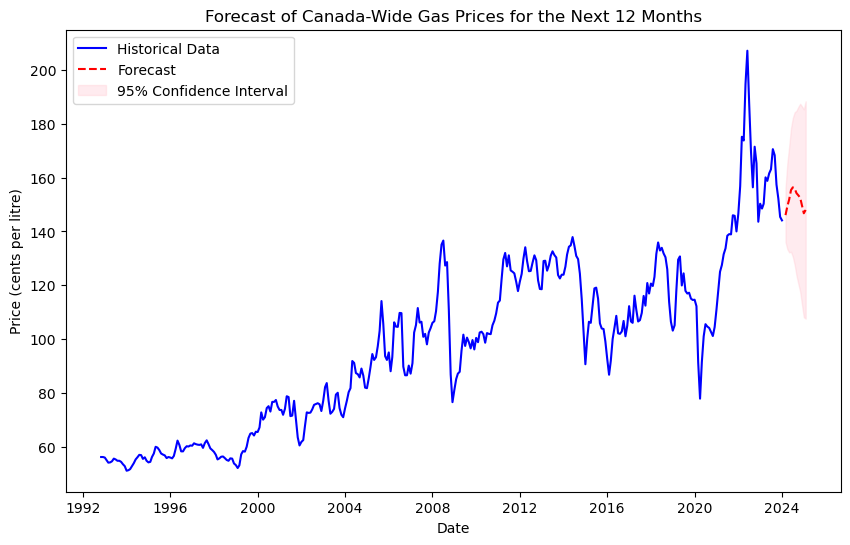

In [48]:
forecast_result = model_fit.get_forecast(steps=12)
forecast_mean = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int()

# Assuming 'forecast_dates_12m' has been defined as the range of dates for the forecast period
forecast_dates_12m = pd.date_range(canada_gas_prices.index[-1], periods=13, freq='M')[1:]

plt.figure(figsize=(10, 6))

# Plotting the historical data
plt.plot(canada_gas_prices.index, canada_gas_prices['Price'], label='Historical Data', color='blue')

# Plotting the forecasted values for the next 12 months
plt.plot(forecast_dates_12m, forecast_mean, label='Forecast', color='red', linestyle='--')

# Adding the confidence intervals as a filled area
plt.fill_between(forecast_dates_12m, 
                 confidence_intervals.iloc[:, 0],  # Lower bound
                 confidence_intervals.iloc[:, 1],  # Upper bound
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Forecast of Canada-Wide Gas Prices for the Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Price (cents per litre)')
plt.legend()
plt.show()

### Just the 12 month period

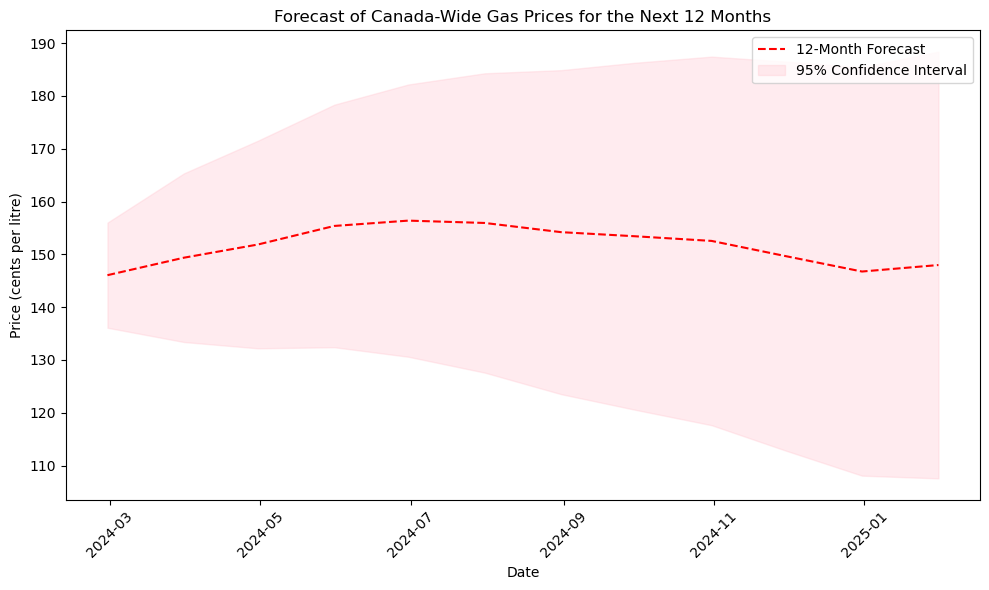

In [49]:

plt.figure(figsize=(10, 6))

# Plotting the forecasted values for the next 12 months
plt.plot(forecast_dates_12m, forecast_mean, label='12-Month Forecast', color='red', linestyle='--')

# Adding the confidence intervals as a filled area
plt.fill_between(forecast_dates_12m, 
                 confidence_intervals.iloc[:, 0],  # Lower confidence interval bound
                 confidence_intervals.iloc[:, 1],  # Upper confidence interval bound
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Forecast of Canada-Wide Gas Prices for the Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Price (cents per litre)')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated date labels
plt.show()

## Forecasted Values and Confidence Intervals

Below is a table displaying the forecasted gas prices for the next 12 months, along with the 95% confidence intervals:

This table offers a clear view of the expected gas prices and their range of uncertainty over the next year.

In [50]:
# Creating a DataFrame for the forecast and confidence intervals
forecast_data = {
    "Month": forecast_dates_12m,
    "Forecasted Price": forecast_mean,
    "Lower 95% CI": confidence_intervals.iloc[:, 0],
    "Upper 95% CI": confidence_intervals.iloc[:, 1]
}

forecast_df = pd.DataFrame(forecast_data)

# Setting the 'Month' column as the index (optional)
forecast_df.set_index("Month", inplace=True)

# Displaying the DataFrame
print(forecast_df)

            Forecasted Price  Lower 95% CI  Upper 95% CI
Month                                                   
2024-02-29        146.056129    136.100057    156.012202
2024-03-31        149.366762    133.397805    165.335719
2024-04-30        151.863416    132.202199    171.524632
2024-05-31        155.382103    132.411688    178.352518
2024-06-30        156.390556    130.605797    182.175315
2024-07-31        155.946917    127.598866    184.294967
2024-08-31        154.204717    123.516780    184.892654
2024-09-30        153.426962    120.561558    186.292365
2024-10-31        152.546409    117.640487    187.452330
2024-11-30        149.670671    112.836697    186.504644
2024-12-31        146.748198    108.083222    185.413175
2025-01-31        147.979213    107.566026    188.392400


## Conclusion

Forecasting gas prices with the SARIMA model provides valuable insights for planning and decision-making. This document demonstrated how to perform such forecasts, visualize the predictions with confidence intervals, and present the data in a structured table.

## Comments on Daily Forecasting

Directly forecasting daily gas prices for the next month with a monthly model is outside the scope of the SARIMA model's capabilities without additional data or assumptions. For accurate daily forecasts, obtaining and modeling daily data is the recommended approach.